In [2]:
import util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%precision 4
%matplotlib inline
util.scale_plot_size(1.5)
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import IPython.core.display as di
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [11]:
w_forcast = widgets.Dropdown(options=['select player'] + get_players(), value='select player', description='forecast:',disabled=False)
w_forcast.observe(plot_forecast, 'value')
display(w_forcast)

0.512 and 0.955 of all predictions are within 50% and 95% intervals
3.16658385347


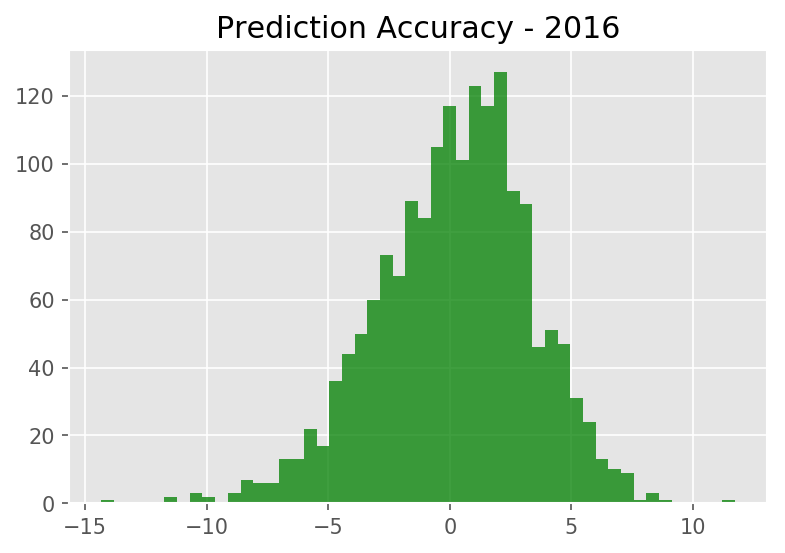

In [12]:
print calc_50_conf(), 'and', calc_95_conf(), 'of all predictions are within 50% and 95% intervals'
plot_prediction_accuracy()

In [5]:
def plot_prediction_accuracy():
    sql_txt = '''
    select ((p.score).mean - s.score) as error from scores s, stan_prediction p
        where s.year = p.year
        and s.player_id = p.player_id
        and s.permanent_tournament_id = p.permanent_tournament_id
        and p.tag = '30-50'
        and s.round = p.round
    '''
    series = util.pd_from_sql(sql_txt)['error']
    plt.hist(series.as_matrix().tolist(), 50, facecolor='green', alpha=0.75)
    foo = plt.title('Prediction Accuracy - 2016')

In [6]:
def plot_forecast(name):
    if type(name) is not str:
        name = name['new']   
    player_df = get_player_scores(name)
    min_score, max_score = player_df['score'].min(), player_df['score'].max()
    plt.gcf().clear()
    plt.plot(range(0, len(player_df)), player_df['score'], label="actual")
    plt.errorbar(range(0, len(player_df)), player_df['mean'], player_df['sd'], label='predicted')
    y_bottom, _ = plt.gca().get_ylim()
    plt.gca().set_ylim([y_bottom,max_score+4])
    plt.title(name + ' - 2016', loc='center')
    plt.legend(loc='upper right')
    plt.xlabel('Rounds 31 - ' + str(30 + len(player_df)))

In [7]:
def get_player_scores(name):
    sql_txt = '''
        select name, date, s.permanent_tournament_id, s.round, (sp.score).mean, (sp.score).sd,  s.score 
        from players p, stan_prediction sp , scores s
        where p.player_id = sp.player_id
        and p.player_id = s.player_id
        and p.name like %s
        and s.permanent_tournament_id = sp.permanent_tournament_id
        and s.round = sp.round
        and s.year = sp.year
        and sp.tag like '30-50' 
        order by date;
        '''
    return util.pd_from_sql(sql_txt, [name])

In [8]:
def get_players():
    sql_txt = '''
        select name 
        from stats_view
        where year = 2016
        limit 50;
    '''
    return util.pd_from_sql(sql_txt)['name'].as_matrix().tolist()

In [9]:
def calc_50_conf():
    sql_txt = '''
    select count(*) from scores s, stan_prediction p
        where s.year = p.year
        and s.player_id = p.player_id
        and s.permanent_tournament_id = p.permanent_tournament_id
        and p.tag = '30-50'
        and s.round = p.round
        and s.score > (p.score).p_25
        and s.score < (p.score).p_75;
    '''
    success = util.exec_sql(sql_txt, True)[0][0]
    sql_txt = '''
    select count(*) from stan_prediction 
        where tag = '30-50'
    '''
    total = util.exec_sql(sql_txt, True)[0][0]
    return round(success/float(total), 3)

In [10]:
def calc_95_conf():
    sql_txt = '''
        select count(*) from scores s, stan_prediction p
        where s.year = p.year
        and s.player_id = p.player_id
        and s.permanent_tournament_id = p.permanent_tournament_id
        and p.tag = '30-50'
        and s.round = p.round
        and s.score > (p.score).p_025
        and s.score < (p.score).p_975;
    '''
    success = util.exec_sql(sql_txt, True)[0][0]
    sql_txt = '''
    select count(*) from stan_prediction 
        where tag = '30-50'
    '''
    total = util.exec_sql(sql_txt, True)[0][0]
    return round(success/float(total), 3)